In [1]:
import mfem.ser as mfem
import matplotlib.pylab as plt
import math

In [2]:
import numpy as np
def plot_GridFun(grid, mesh):
    '''NOTE, this only works with uniform square girdfunctions'''
    ar = np.array(mesh.GetVertexArray())  
    ydim = int(np.sum(ar[:,0] == ar[0][0]))
    xdim = int(len(grid.GetDataArray())/ydim)
    plt.imshow(grid.GetDataArray().reshape([xdim,ydim]))

In [3]:
def plot_GridFun(grid):
    '''NOTE, this only works with uniform square girdfunctions'''
    mesh = grid.FESpace().GetMesh()
    ar = np.array(mesh.GetVertexArray())  
    ydim = int(np.sum(ar[:,0] == ar[0][0]))
    xdim = int(len(grid.GetDataArray())/ydim)
    plt.imshow(grid.GetDataArray().reshape([xdim,ydim]))

In [4]:
mesh_file = "Cmesh_4x4_AMR_M02.mesh"
dsF_file = "CdsF_4x4_AMR_M02.txt"
# mesh_file = "Mesh_40x30_A1.mesh"
# dsF_file = "dsF_40x30_A1.txt"
AMR = 0
order = 1

visualization = True

dbc_w_val = -0.0			
dbc_e_val = -0.0
dbc_s_val = -0.0
dbc_n_val = -0.0			
	
nbc_w_val = 0.0			
nbc_e_val = 0.0	
nbc_s_val = 0.0
nbc_n_val = 0.0
			
mat_val = 1.0			
zeta = 1.0*0.5 
dh = 3.25e-5
#dh = 1.0/40				
NB = 0.02				
eps = 1.0e-6

mesh = mfem.Mesh(mesh_file)
#mesh.EnsureNCMesh(True)
fec = mfem.H1_FECollection(order, mesh.Dimension())
fespace = mfem.FiniteElementSpace(mesh, fec)
print("Number of unknowns:" ,fespace.GetTrueVSize())


dSF = mfem.GridFunction(fespace)
nV = dSF.Size()
print("Number of vertices",nV)
# with open(dsF_file) as file:
#     lines = file.readlines()

# print("lines",len(lines))
# for i in range(nV):
#     dSF[i] = float(lines[i])
with open(dsF_file, "r") as myfile:
    for i in range(3084):
        value = myfile.readline()
        dSF[i] = float(value)
        

# with open(dsF_file, "r") as myfile:

#     for i in range(nV):

#         line = myfile.readline()

#         if not line:

#             raise ValueError(f"Unexpected end of file at index {i}")

#         value = float(line.strip())

#         dSF[i] = value
 
    # levels of refinement
if (AMR > 0):
	
	# create an array to store vertex labels of each element
    VertVal = mfem.doubleArray(4)
    Ds2Br = 0 	# distance of an element to the internal boundary	
		
    Lv = AMR
    LvFc = mfem.doubleArray(Lv)  # criteria for refinement
    for i in range(Lv):
        LvFc[i] = 2.5* pow(2,-i)
		
	
		# create an array to store the labels of elements needed to be refined.
    refinement_list = mfem.intArray()

    for Lv in range(AMR):
        for i in range(mesh.GetNE()):
            # get the distance values at the 4 vertices
            dSF.GetNodalValues(i,VertVal)
		
			# distance from element center to the internal boundary
            Ds2Br = 0.25*(VertVal[0]+VertVal[1]+VertVal[2]+VertVal[3])
		
			# collect the element labels 
            if (abs(Ds2Br) < LvFc[Lv]*dh):
                refinement_list.Append(i)
				

		# mesh refinement
        mesh.GeneralRefinement(refinement_list)
	
		# update relevant objects 
        fespace.Update()
        dSF.Update()
        #plot_GridFun(dSF, mesh)
		
        #Clear refinement list
        refinement_list.DeleteAll() 
		


Number of unknowns: 3505
Number of vertices 4203


In [5]:

print(f"{nV} -- {dSF.Size()}")

# 5. Domain parameter and interface (GridFunction)
psi = mfem.GridFunction(fespace)
AvP = mfem.GridFunction(fespace)
# interpolate domain parameter from distance function
for i in range(dSF.Size()):
    psi[i] = 0.5*(1.0+math.tanh(dSF[i]/(zeta*dh))) + eps
    AvP[i] = -(pow(math.tanh(dSF[i]/(zeta*dh)),2)-1.0)/(2*zeta*dh)
    
# coefficient of the domain parameter
nPs = mfem.GridFunction(fespace)
nAp = mfem.GridFunction(fespace) 	
 	
for i in range(nPs.Size()):
    nPs[i] = psi[i]*mat_val	    # material property
    nAp[i] = AvP[i]*NB			# reaction rate (Neumann BC)
		
# Grid function coefficient for matrix and RHS forming.
cPs = mfem.GridFunctionCoefficient(nPs)
cAp = mfem.GridFunctionCoefficient(nAp) 

# 6. boundary conditions
# Dirichlet BCs. Here imposing on the east boundary 
dbc_w_bdr = mfem.intArray(mesh.bdr_attributes.Max())
dbc_w_bdr.Assign(0)
dbc_w_bdr[0] = 0	# assign a value of 0 to the west boundary  
	
dbc_e_bdr = mfem.intArray((mesh.bdr_attributes.Max()))
dbc_e_bdr.Assign(0) 
#dbc_e_bdr[2] = 1	# assign a value of 1 to the east boundary  	
dbc_e_bdr[2] = 0	# assign a value of 1 to the east boundary  	

dbc_s_bdr = mfem.intArray((mesh.bdr_attributes.Max()))
dbc_s_bdr.Assign(0) 
#dbc_s_bdr[1] = 0	# assign a value of 0 to the south boundary
dbc_s_bdr[1] = 1	# assign a value of 0 to the south boundary  	

dbc_n_bdr = mfem.intArray((mesh.bdr_attributes.Max()))
dbc_n_bdr.Assign(0)
dbc_n_bdr[3] = 0	# assign a value of 0 to the north boundary  	

# assign all Dirichlet nodes to dbc_bdr array
dbc_bdr = mfem.intArray((mesh.bdr_attributes.Max()))
for i in range(mesh.bdr_attributes.Max()):

	if ((dbc_w_bdr[i] > 0) or (dbc_e_bdr[i] > 0) or (dbc_s_bdr[i] > 0) or (dbc_n_bdr[i] > 0)):
         dbc_bdr[i] = 1

            
dbc_bdr.Print()	
	
	# Neumann BCs. Here imposing on the east, south, and north boundaries.
nbc_w_bdr = mfem.intArray((mesh.bdr_attributes.Max()))
nbc_w_bdr.Assign(0) 
nbc_w_bdr[0] = 1;	# assign a value of 1 to the corresponding boundary  
	
nbc_e_bdr = mfem.intArray((mesh.bdr_attributes.Max()))
nbc_e_bdr.Assign(0)
#nbc_e_bdr[2] = 0	# assign a value of 0 to the corresponding boundary
nbc_e_bdr[2] = 1	# assign a value of 0 to the corresponding boundary  	


nbc_s_bdr = mfem.intArray((mesh.bdr_attributes.Max()))
nbc_s_bdr.Assign(0) 
#nbc_s_bdr[1] = 1	# assign a value of 1 to the corresponding boundary 
nbc_s_bdr[1] = 0	# assign a value of 1 to the corresponding boundary  	
 	

nbc_n_bdr = mfem.intArray((mesh.bdr_attributes.Max()))
nbc_n_bdr.Assign(0)
nbc_n_bdr[3] = 1	# assign a value of 1 to the corresponding boundary  	
	
# assign all Neumann nodes to nbc_bdr array
nbc_bdr = mfem.intArray((mesh.bdr_attributes.Max()))
for i in range(mesh.bdr_attributes.Max()):
	if ((nbc_w_bdr[i] > 0) or (nbc_e_bdr[i] > 0) or (nbc_s_bdr[i] > 0) or (nbc_n_bdr[i] > 0)):
         nbc_bdr[i] = 1
            

nbc_bdr.Print()
	

# use dbc_bdr array to extract all node labels of Dirichlet BC
ess_tdof_list = mfem.intArray(0)		
fespace.GetEssentialTrueDofs(dbc_bdr, ess_tdof_list)
'''' setting up FEM solver
7. Define the solution x as a finite element grid function in fespace. Set
the initial guess to zero, which also sets the boundary conditions. '''
x = mfem.GridFunction(fespace)
x.Assign(0.0)
			
# assign known values to the DBC nodes	
dbc_Coef = mfem.ConstantCoefficient(dbc_e_val)	# coefficient of DBC
x.ProjectBdrCoefficient(dbc_Coef, dbc_bdr)
	
	
# 8. Set up the bilinear form a(.,.) corresponding to the -Delta operator.
a = mfem.BilinearForm(fespace)
a.AddDomainIntegrator(mfem.DiffusionIntegrator(cPs))
a.Assemble()


# 9. Set up the linear form b(.) corresponding to the right-hand side.
matCoef_R = mfem.ConstantCoefficient(-1*mat_val)	# material coefficient on RHS, negative accounts for the convention in MFEM	
nbcCoef = mfem.ConstantCoefficient(nbc_w_val)
m_nbcCoef = mfem.ProductCoefficient(matCoef_R, nbcCoef)
	
b = mfem.LinearForm(fespace)
b.AddDomainIntegrator(mfem.DomainLFIntegrator(cAp))
b.AddBoundaryIntegrator(mfem.BoundaryLFIntegrator(m_nbcCoef), nbc_bdr)
b.Assemble()	
	


# 10. Form the linear system A X = B. This includes eliminating boundary
#    conditions, applying AMR constraints, and other transformations.
A = mfem.SparseMatrix()
B, X = mfem.Vector(), mfem.Vector()
	 
a.FormLinearSystem(ess_tdof_list, x, b, A, X, B)


# 11. Solve the system using PCG with symmetric Gauss-Seidel preconditioner.
M = mfem.GSSmoother(A)
mfem.PCG(A, M, B, X, 1, 200, 1e-12, 0.0)



# 12. Recover the solution x as a grid function and save to file. The output
#     can be viewed using GLVis as follows: "glvis -m mesh.mesh -g sol.gf"
a.RecoverFEMSolution(X, b, x)
   
# TODO: Talk to dirk to get the animate funciton  
# for i in range(200):
#     mfem.PCG(A, M, B, X, 1, 1, 1e-12, 0.0)
#     a.RecoverFEMSolution(X, b, x)
#     plot_GridFun(x)
#     animate()
   
# 13. Output results
x.Save("sol_A1.gf")
mesh.Save("mesh_A1.mesh")
psi.Save("psi_A1.gf")
AvP.Save("AvP_A1.gf")


# 14. output vertex coordinates following the order of GridFucntion
Crdt = mfem.GridFunction(fespace)
Crdt.Save("N_Crd_A1.gf")
		   
	
# 15. Send the solution by socket to a GLVis server.
# if (visualization):
#     vishost = "localhost"
#     visport   = 19916
#     sol_sock = mfem.socketstream(vishost, visport)
#     sol_sock.precision(8)
#     sol_sock.send_solution(mesh, x)

      

4203 -- 4203
149875 1 0 0
1 0 1 1
   Iteration :   0  (B r, r) = 1.53718e-07
   Iteration :   1  (B r, r) = 6.0438e-08
   Iteration :   2  (B r, r) = 3.45217e-08
   Iteration :   3  (B r, r) = 3.03215e-08
   Iteration :   4  (B r, r) = 5.30196e-08
   Iteration :   5  (B r, r) = 8.86495e-08
   Iteration :   6  (B r, r) = 1.59852e-07
   Iteration :   7  (B r, r) = 1.45504e-07
   Iteration :   8  (B r, r) = 1.08404e-07
   Iteration :   9  (B r, r) = 8.62775e-08
   Iteration :  10  (B r, r) = 9.37942e-08
   Iteration :  11  (B r, r) = 1.10551e-07
   Iteration :  12  (B r, r) = 1.32447e-07
   Iteration :  13  (B r, r) = 8.74408e-08
   Iteration :  14  (B r, r) = 6.96875e-08
   Iteration :  15  (B r, r) = 7.97632e-08
   Iteration :  16  (B r, r) = 9.26661e-08
   Iteration :  17  (B r, r) = 9.6124e-08
   Iteration :  18  (B r, r) = 9.65079e-08
   Iteration :  19  (B r, r) = 8.66128e-08
   Iteration :  20  (B r, r) = 6.45109e-08
   Iteration :  21  (B r, r) = 5.12314e-08
   Iteration :  22  (B

In [6]:
# vertices = mesh.GetVertexArray()
# ar = np.array(vertices)
# X = ar[:,0].reshape([41, 31])
# Y = ar[:,1].reshape([41, 31])
# Z = x.GetDataArray().reshape([41, 31])
# fig = plt.figure()
# ax = fig.add_subplot(111, projection='3d')
# ax.plot_surface(X, Y, Z, cmap='viridis')
# plt.show()



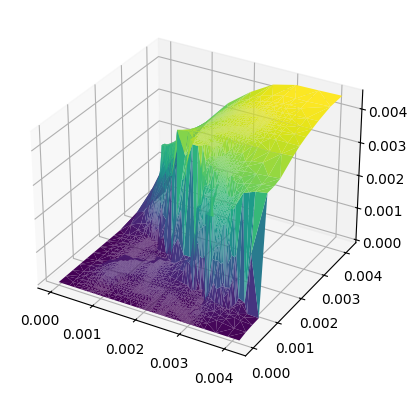

In [7]:
from matplotlib import cm
from matplotlib.colors import ListedColormap
vertices = mesh.GetVertexArray()
ar = np.array(vertices)
X = ar[:,0]
Y = ar[:,1]
Z = x.GetDataArray()
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_trisurf(X, Y, Z, cmap="viridis")
#ax.plot_trisurf(X, Y, Z, cmap='viridis')
plt.show()

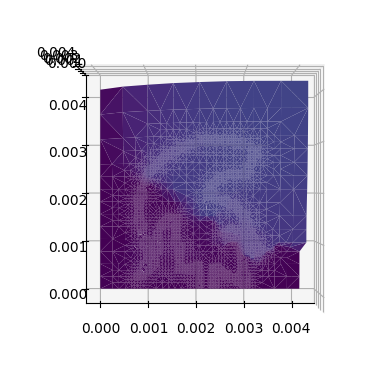

In [8]:
from matplotlib import cm
from matplotlib.colors import ListedColormap
vertices = mesh.GetVertexArray()
ar = np.array(vertices)
X = ar[:,0]
Y = ar[:,1]
Z = x.GetDataArray()
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
cmap = ListedColormap(cm.viridis(np.linspace(0.0, 0.2, 256)))
ax.plot_trisurf(X, Y, Z, cmap=cmap)
#ax.plot_trisurf(X, Y, Z, cmap='viridis')
ax.view_init(elev=90, azim= 270)
plt.show()

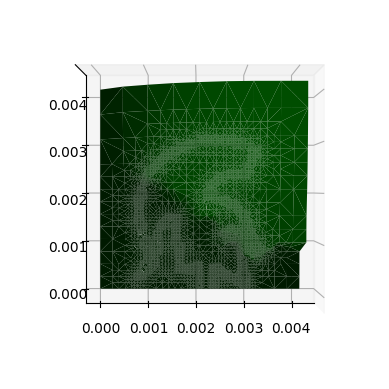

In [9]:
from matplotlib import cm
from matplotlib.colors import ListedColormap
from matplotlib.colors import LinearSegmentedColormap
vertices = mesh.GetVertexArray()
ar = np.array(vertices)
X = ar[:,0]
Y = ar[:,1]
Z = x.GetDataArray()
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
cmap = LinearSegmentedColormap.from_list("darkest_green", ["#001a00", "#002d00", "#004d00"])
ax.plot_trisurf(X, Y, Z, cmap=cmap)
#ax.plot_trisurf(X, Y, Z, cmap='viridis')
ax.view_init(elev=90, azim= -90)
ax.set_zticks([])          # Hide Z tick marks
ax.set_zticklabels([])     # Hide Z tick labels
ax.set_zlabel("") 
plt.show()